<a href="https://colab.research.google.com/github/enricoaquilina/webnlg2023/blob/main/WebNLG_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install datasets 
!pip install sentencepiece
!pip install transformers[sentencepiece]
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 6.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.4 MB/s eta 0:00

In [3]:
import gc
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
import os


In [4]:
import math
train_df = pd.read_csv('/content/drive/MyDrive/WebNLG/2023-Challenge/data/processed/webNLG2020_train.csv', index_col=[0])
train_df=train_df.iloc[:1473,:]
train_df=train_df.sample(frac=1)
batch_size=8
num_of_batches=math.floor(len(train_df)/batch_size)

In [5]:
num_of_batches

171

In [6]:
train_df.shape

(1375, 3)

In [7]:
train_df

,prefix,input_text,target_text
1307,webNLG,['1101_Clematis | mass | 5.7 (kilograms)'],"['1101 Clematis għandu massa ta ’ 5. 7 kg.', '..."
1323,webNLG,['11264_Claudiomaccone | periapsis | 296521000...,['11264 Claudiomaccone għandu perijażi ta ’ 29...
429,webNLG,['Alfredo_Zitarrosa | birthPlace | Uruguay'],"['Alfredo Zitarrosa twieled fl-Urugwaj.', 'Il-..."
1258,webNLG,['107_Camilla | discoverer | C._Woods'],"['C Woods sabet 107 Camilla.', '107 Camilla ns..."
1278,webNLG,['1097_Vicia | temperature | 171.0 (kelvins)'],['1097 Vicia għandha temperatura ta ’ 171. 0 k...
...,...,...,...
649,webNLG,['A.C._Milan | manager | Siniša_Mihajlović'],['Siniša Mihajlović huwa l-maniġer ta’ A.C. Mi...
539,webNLG,['Montevideo | country | Uruguay'],"['Montevideo jinsab fil-pajjiż tal-Urugwaj.', ..."
794,webNLG,['Aleksandr_Prudnikov | club | FC_Anzhi_Makhac...,['Aleksandr Prudnikov jindika għall-FC Anzhi M...
355,webNLG,['Agustín_Barboza | birthPlace | Paraguay'],['Il-post tat-twelid ta’ Agustin Barboza huwa ...


In [8]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


In [9]:
%%capture
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration,Adafactor

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

In [10]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)


In [11]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [12]:
num_of_epochs=1


In [13]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):

    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'    
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
  
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.7867197267144744
Running epoch: 2


Epoch: 2 , Running loss: 0.3837981874134108
Running epoch: 3


Epoch: 3 , Running loss: 0.2776198228548842
Running epoch: 4


Epoch: 4 , Running loss: 0.2228719645686317


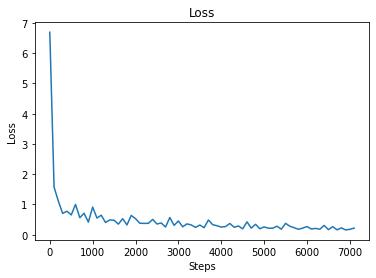

In [14]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [19]:
model.eval()
input_ids = tokenizer.encode("WebNLG: Russia | leader | Putin</s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])
     

"<pad>['Il-mexxej tar-Russja hu"

In [16]:
torch.save(model.state_dict(),'pytorch_model.bin')
